In [1]:
import pymysql
import numpy as np
import pandas as pd
from scipy import optimize
import datetime as dtt
from WindPy import w
import datetime as dtt
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [149]:
class WindIrsData(object):
    """从WIND中提取利率互换收盘价数据"""
    def __init__(self, type):
        """存储不同种类的IRS代码，主要期限为9M, 1Y, 2Y, 3Y, 4Y, 5Y"""
        if type == "FR007":
            self.codes = ["M0218007", "M0218008", "M0218009", "M0218010", "M0218011", "M0218012"]
            self.columns = ["FR007S9M", "FR007S1Y", "FR007S2Y", "FR007S3Y", "FR007S4Y", "FR007S5Y"]
            self.outliers = [dtt.date(2015, 5, 22)]
        elif type == "SHIBOR3M":
            self.codes = ["M0218016", "M0218017", "M0218018", "M0218019", "M0218020", "M0218021"]
            self.columns = ["SHI3MS9M", "SHI3MS1Y", "SHI3MS2Y", "SHI3MS3Y", "SHI3MS4Y", "SHI3MS5Y"]
            self.outliers = [dtt.date(2015, 5, 6), dtt.date(2015, 6, 4), dtt.date(2015, 6, 10), dtt.date(2015, 9, 21)]
        else:
            raise ValueError("不被接受的参数值type")
        self.wdata = None
        self.times = None
        self.data = None
        self.df = None
    
    def extract(self, dt1=dtt.date(2015, 1, 1), dt2=dtt.date(2018, 12, 17)):
        "从Wind中提取相应品种利率互换的日收盘价数据"
        wData = w.edb(self.codes, dt1, dt2)
        if wData.ErrorCode == 0:
            self.wdata = wData
            self.times = wData.Times
            self.data = wData.Data
            self.df = pd.DataFrame(list(zip(*self.data)), index=pd.to_datetime(self.times), columns=self.columns)
            self.df.drop(self.outliers, inplace=True)
        else:
            raise ValueError("{}".format(wData.ErrorCode))
    
    def spreads(self):
        """分别返回9M*1Y，1*5Y，2*5Y，3*5Y，4*5Y的利差数据"""
        spreads = [self.df[self.columns[1]]-self.df[self.columns[0]], self.df[self.columns[5]]-self.df[self.columns[1]], \
                  self.df[self.columns[5]]-self.df[self.columns[2]], self.df[self.columns[5]]-self.df[self.columns[3]],\
                  self.df[self.columns[5]]-self.df[self.columns[4]]]
        res = pd.concat(spreads, axis=1)
        res.columns = ["9M*1Y", "1*5Y", "2*5Y", "3*5Y", "4*5Y"]
        return res

In [150]:
class Stats(object):
    """本类用于对利率互换期限利差之间的相互关系进行统计"""
    def __init__(self, type="FR007", dt1=dtt.date(2015, 1, 1), dt2=dtt.date(2018, 12, 17)):
        """初始化，type为利率互换基础利率品种，dt1为样本开始日期，dt2为样本结束日期"""
        self.type = type
        self.dt1 = dt1
        self.dt2 = dt2
        self.wid = WindIrsData(self.type)
        self.wid.extract(dt1, dt2)
        self.spreads = self.wid.spreads()
        
    def get_params(self, dt1, dt2):
        """以1*5Y为解释变量，分别以9M*1Y，2*5Y，3*5Y，4*5Y为被解释变量进行单元线性回归（不带常数项），返回解释变量的系数"""
        params = []
        spreads = self.spreads.loc[(self.spreads.index>dt1)&(self.spreads.index<=dt2)]
        fields = ["9M*1Y", "2*5Y", "3*5Y", "4*5Y"] # 因变量字段名
        field = "1*5Y" # 自变量字段名
        for f in fields:
            data = spreads[[field, f]].dropna()
            x = data.iloc[:, 0]
            y = data.iloc[:, 1]
            model = sm.OLS(y, x)
            res = model.fit()
            params.append(res.params[0])
        return params
    
    def roll_params(self, roll_period):
        """使用滚动的方式计算单元线性回归参数，样本期为roll_period"""
        res = []
        dts = self.spreads.index
        for i in range(len(dts)-roll_period):
            dt1 = dts[i]
            dt2 = dts[i+roll_period]
            params = self.get_params(dt1, dt2)
            res.append(params)
        res = pd.DataFrame(res, index=pd.to_datetime(dts[roll_period:]), columns=["9M*1Y", "2*5Y", "3*5Y", "4*5Y"])
        return res      

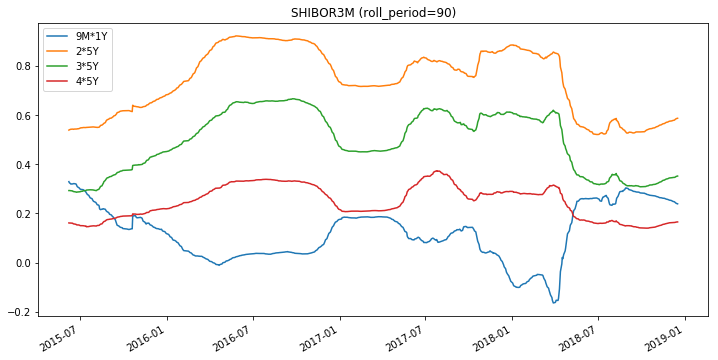

In [155]:
type = "SHIBOR3M"
stats = Stats(type)
df = stats.roll_params(90)
df.plot(figsize=(12, 6), title="{} (roll_period=90)".format(type))
plt.legend(loc="upper left")
plt.show()

In [156]:
df.to_csv("shibor3m.csv", sep=",", header=True, index=True)

In [148]:
spreads.to_csv("spreads.csv", sep=",", header=True, index=True)

In [128]:
wid=WindIrsData("SHIBOR3M")
wid.extract()
spreads=wid.spreads()

KeyError: '2015-5'

In [123]:
spreads.loc[dtt.date(2015, 5, 22)]

KeyError: 'the label [2015-05-22] is not in the [index]'